# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

In [5]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


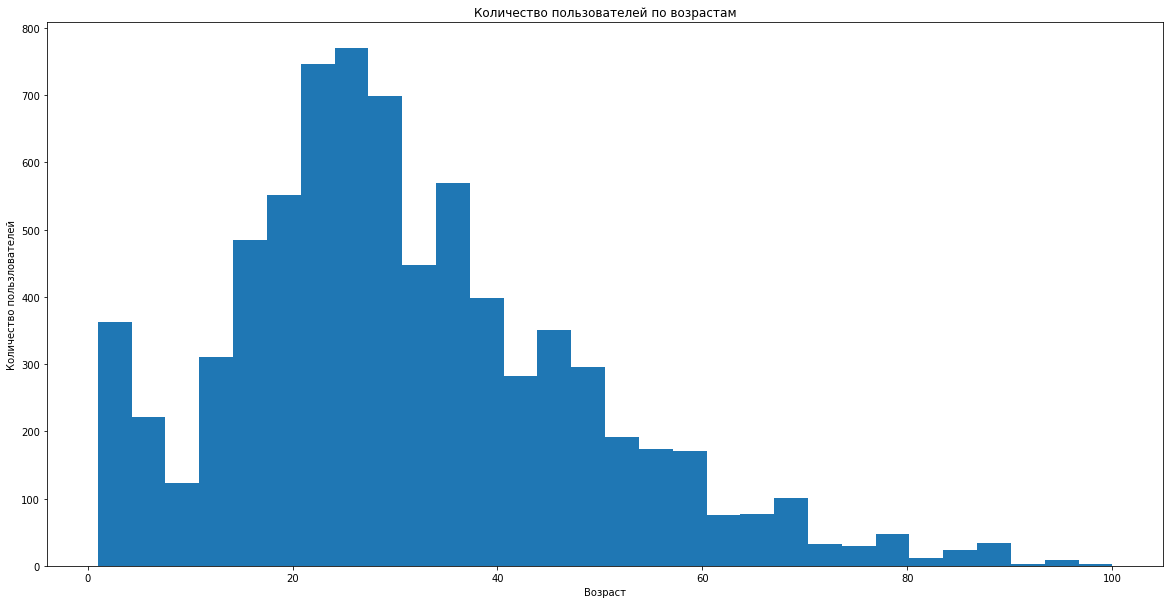

In [27]:
x = labels['real_age']

plt.figure(figsize=(20, 10))
plt.hist(x, bins = 30)
plt.xlabel('Возраст')
plt.ylabel('Количество пользлователей')
plt.title('Количество пользователей по возрастам')
plt.show()

***Самый часто встречающейся возраст это 20-30 лет также людей за 70 почти нет.***

Age 4


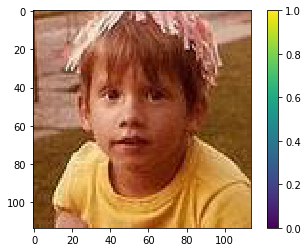

Age 18


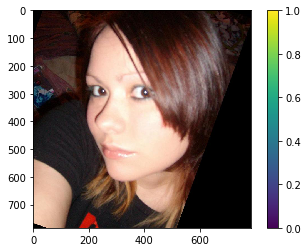

Age 80


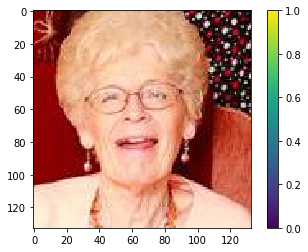

Age 50


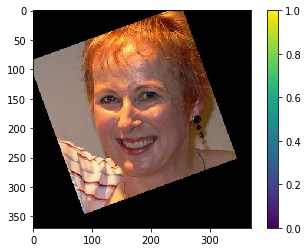

Age 17


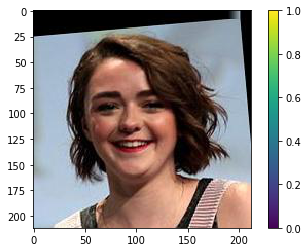

Age 27


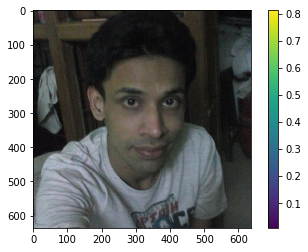

Age 24


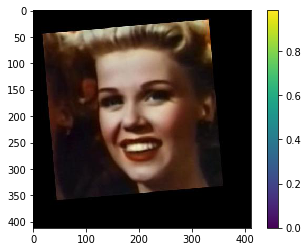

Age 43


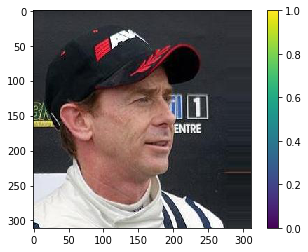

Age 26


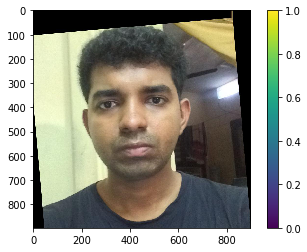

Age 39


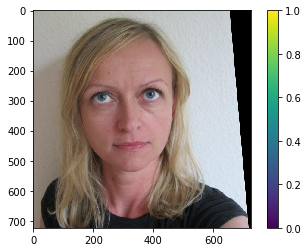

In [5]:
for i in range(10):
    print('Age', labels.loc[i]['real_age'])

    image = Image.open(r'/datasets/faces/final_files/'+labels.loc[i]['file_name']) # Читаем изображение
    array = np.array(image)
    array = array/255
    plt.imshow(array)
    plt.colorbar()
    plt.show()
    

***Могу сказать что некоторые изображения не ровные и имеют черные полосы по бокам. Так же цвета и четкость изображений на некоторых фотографиях довольно плохие. Некоторые очень черные или наоборот белые.***

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
    
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
 
def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255, 
        horizontal_flip=True,
        vertical_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
            pd.read_csv(path + 'labels.csv'), 
            path + 'final_files', 
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=20,
            subset='training',
            class_mode='raw',
            seed=12345) 

    return train_datagen_flow
 
def load_test(path):
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        pd.read_csv(path + 'labels.csv'), 
        path + 'final_files', 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=20,
        subset='validation',
        class_mode='raw',
        seed=12345) 

    return test_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
 
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=16, epochs=5, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model
    
```

- <class 'tensorflow.python.keras.engine.sequential.Sequential'>
- Train for 285 steps, validate for 95 steps
- Epoch 1/5
- 285/285 - 53s - loss: 250.1118 - mae: 11.5857 - val_loss: 445.1804 - val_mae: 16.0479
- Epoch 2/5
- 285/285 - 43s - loss: 112.7669 - mae: 8.0830 - val_loss: 236.3706 - val_mae: 11.4477
- Epoch 3/5
- 285/285 - 43s - loss: 91.0683 - mae: 7.2615 - val_loss: 106.4332 - val_mae: 7.7401
- Epoch 4/5
- 285/285 - 43s - loss: 68.0588 - mae: 6.3212 - val_loss: 110.6064 - val_mae: 7.9041
- Epoch 5/5
- 285/285 - 43s - loss: 58.5825 - mae: 5.8165 - val_loss: 79.4201 - val_mae: 6.6333

- 95/95 - 10s - loss: 79.4201 - mae: 6.6333
- Test MAE: 6.6333

## Анализ обученной модели

- Основные изменеия в модели это довольно низкий Адам - 0.0001, а так же 5 эпох. В тренировочном датасете я повренул картинки по вертекали и горинтали. Так как некотрые картинки не очень прямо стоят. 
- МАЕ 6.6 это довольно хороший результат.
- Данная сеть имеет довольно небольшую погрешность и ее можно использовать в данном бизнесе для опознания возраста клиента, но она предсказывает не достаточно хорошо и поледнее решение должно быть за человеком поле просмотра результата. Также сейчас все носят маски и я сомневаюсь что модель сможет нормально опознать человека в маске.